# Tutorial - Criando GAN

In [12]:
using Flux
using Statistics, Distributions
using Plots

Suponha que observamos os dados acima e desconhecemos a função que os geraram.
O que queremos então fazer é criar uma rede neural que gera dados
dessa distribuição, onde temos acesso somente a essas amostras.

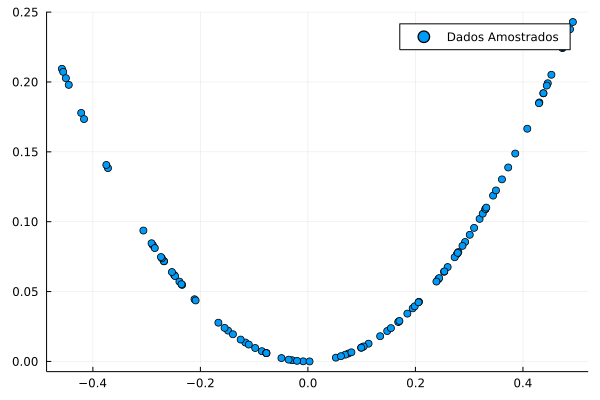

In [27]:
function generate_real_data(n)
    x1 = rand(1,n) .- 0.5
    x2 = x1 .* x1
    return vcat(x1,x2)
end

dados = generate_real_data(100)
x,y = dados[1,:], dados[2,:]
scatter(x,y, label="Dados Amostrados")

### Construindo o Discriminador e o Gerador

In [29]:
function D()
    return Chain(
            Dense(2, 25,relu),
            Dense(25,1)
            )
end

function G(latent_dim::Int)
    return Chain(
            Dense(latent_dim, 15,relu),
            Dense(15,2)
            )
end;


A GAN original busca resolver o seguinte problema de otimização:

$$
\min_{G} \max_D V(D,G) =
\mathbb{E}_{P_{data}(x)}\left[\log{(D(x))}\right]+
\mathbb{E}_{P_z(z)}\left[\log(1-D(G(z))\right],
$$

Assim, temos uma função de perda para treinar $D$ e outra para treinara $G$.

In [33]:
loss_D(x, y, dscr) = sum(Flux.Losses.logitbinarycrossentropy(dscr(x), y));

loss_G(z,gen,dscr) = sum(Flux.Losses.logitbinarycrossentropy(dscr(gen(z)),1))

loss_G (generic function with 1 method)

### Vamos descrever a função para treinar a rede $D$.

In [34]:
function trainDiscriminator!(dscr,gen,train_size)
    real = generate_real_data(train_size)
    fake = gen(rand(5,train_size))

    X    = hcat(real,fake)
    Y    = vcat(ones(train_size),zeros(train_size))
    data = Flux.Data.DataLoader((X, Y'), batchsize=1,shuffle=true);
    for d in data
        gs = gradient(Flux.params(dscr)) do
            l = loss_D(d...,dscr)
        end
        Flux.update!(opt, Flux.params(dscr), gs)
    end
end


function trainGenerator!(gen,dscr,train_size)
    noise = rand(5,train_size)
    data = Flux.Data.DataLoader(noise, batchsize=128,shuffle=true);
    for d in data
        gs = gradient(Flux.params(gen)) do
            l = loss_G(d,gen,dscr)
        end
        Flux.update!(opt, Flux.params(gen), gs)
    end
    fake_generated = gen(rand(5,train_size))
end

trainGenerator! (generic function with 1 method)

In [35]:
gen  = G(5)
dscr = D()
opt  = ADAM()
train_size = 2000

2000

In [36]:
epochs = 200
for e in 1:epochs
    trainDiscriminator!(dscr,gen,Int(train_size/2))
    trainGenerator!(gen,dscr,train_size)
    if e%10 == 0
        real = generate_real_data(train_size)
        fake = gen(rand(5,train_size))
        @show mean(dscr(real)),mean(dscr(fake))
    end
end

(mean(dscr(real)), mean(dscr(fake))) = (1.1496031303490268, -0.29282772821405606)
(mean(dscr(real)), mean(dscr(fake))) = (0.6863752056390546, -0.3124356188415745)
(mean(dscr(real)), mean(dscr(fake))) = (0.41011185684364637, -0.5508499272265934)
(mean(dscr(real)), mean(dscr(fake))) = (0.8952879817794485, -0.603463430219438)
(mean(dscr(real)), mean(dscr(fake))) = (0.37573169744786084, -0.22267044570058772)
(mean(dscr(real)), mean(dscr(fake))) = (0.3402402883942394, -0.16455238595892951)
(mean(dscr(real)), mean(dscr(fake))) = (0.3222121653094703, -0.018457761813269757)
(mean(dscr(real)), mean(dscr(fake))) = (0.3360719119515844, -0.002874605714415404)
(mean(dscr(real)), mean(dscr(fake))) = (0.4420039946526387, 0.28994956993780935)
(mean(dscr(real)), mean(dscr(fake))) = (0.036525677324942225, -0.26189382974403397)
(mean(dscr(real)), mean(dscr(fake))) = (0.2362347621594156, -0.041150405693521866)
(mean(dscr(real)), mean(dscr(fake))) = (0.06132151739296286, -0.21279394050585473)
(mean(dscr(re

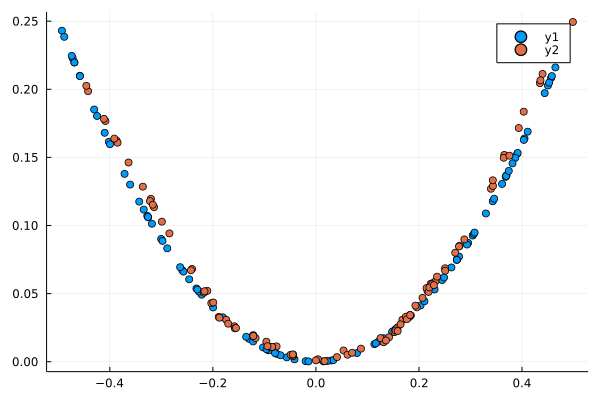

In [37]:
real = generate_real_data(train_size)
fake = gen(rand(5,train_size))
scatter(real[1,1:100],real[2,1:100])
scatter!(fake[1,1:100],fake[2,1:100])